In [1]:
import torch
from torch import nn # neural network components
import matplotlib.pyplot as plt # visualisation
import scrollable_output
import numpy as np

torch.__version__

'2.1.2'

In [20]:
# known data from linear regression formula
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [3]:
len(X), len(y)

(50, 50)

In [4]:
# 80 / 20 split, train test
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
# Visualise
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions
    """
    plt.figure(figsize=(10,7))
    
    # plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    # plot testing data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    # Are there predictions?
    if predictions is not None:
        # plot predictions
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    
    # Show legend
    plt.legend(prop={"size": 14})

In [6]:
from torch import nn

# Build model - linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in pytorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))
        
    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
        return self.weights * x + self.bias # this is the linear regression formula                      
                                        

In [7]:
# torch.nn - computational graph building blocks (such as neural network)
# torch.nn.Parameter - what parameters the model should try and learn
# torch.nn.Module - base class for all neural network modules - override forward()
# torch.optim - optimisers, helps with gradient descent
# def forward() - all nn.Module subclasses require overwrite forward, defines the computation

# Using Gradient Descent and Back Propagation

# check model contents

torch.manual_seed(42)

model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [10]:
# predict using torch.inference_mode()

with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

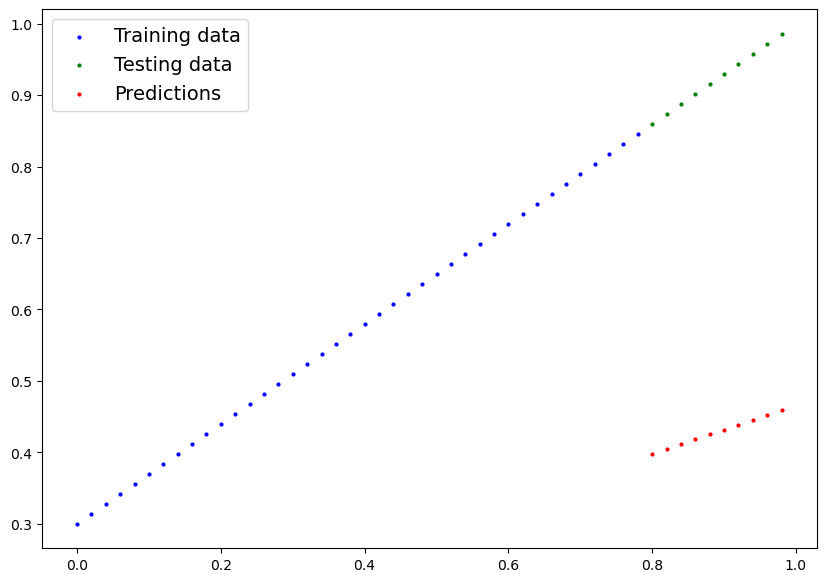

In [11]:
plot_predictions(predictions=y_preds)

In [12]:
# set up loss function
loss_fn = nn.L1Loss()

# set up optimiser - stochastic gradient descent - starts randomly then adjusts gradually
optimiser_fn = torch.optim.SGD(params=model_0.parameters(),
                               lr = 0.0001) # lr = learning rate, most important hyperparameter

In [13]:
# Training loop and testing loop

epochs = 20000 # hyperparameter - we set it ourselves

# track values during training
epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
    epoch_count.append(epoch)
    model_0.train() # train mode in pytorch set
    
    # forward pass
    y_pred = model_0(X_train)
    
    # calculate loss (input, target)
    loss = loss_fn(y_pred, y_train)
    loss_values.append(loss)
    
    # optimiser zero grad
    optimiser_fn.zero_grad()
    
    # perform back propogation
    loss.backward()
    
    # step the optimizer
    optimiser_fn.step()
    
    # Testing against the test data
    model_0.eval()
    # inference mode turns off gradient tracking
    with torch.inference_mode():

        # forward pass
        test_pred = model_0(X_test)

        # calculate the loss value
        test_loss = loss_fn(test_pred, y_test)
        
        test_loss_values.append(test_loss)

    if epoch % 5000 == 0:    
        print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")
        
print(model_0.state_dict())

Epoch: 0 | Test: 0.31288138031959534 | Test loss: 0.4944015145301819
Epoch: 5000 | Test: 0.04159027710556984 | Test loss: 0.10100533813238144
Epoch: 10000 | Test: 0.024338718503713608 | Test loss: 0.056904666125774384
Epoch: 15000 | Test: 0.007159063126891851 | Test loss: 0.01673126220703125
OrderedDict([('weights', tensor([0.6999])), ('bias', tensor([0.3000]))])


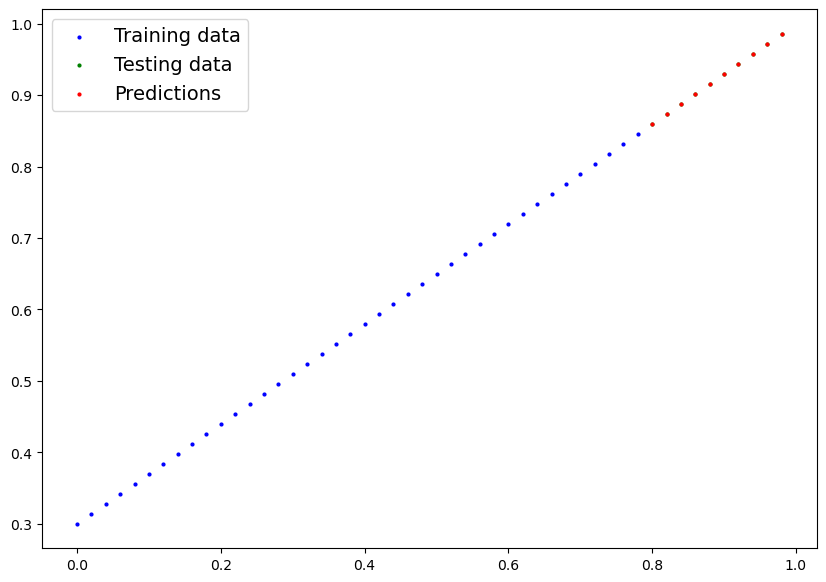

In [14]:
# turns off model properties related to training
model_0.eval()
# inference mode turns off gradient tracking, Performance improvements
with torch.inference_mode():
    y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

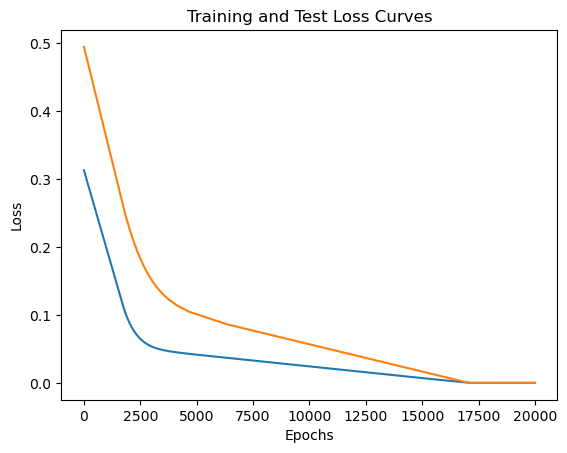

In [15]:
# Plot the outputs of the loss function
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curves')
plt.show()

In [27]:
from pathlib import Path

# Saving and Loding Models
# Pickle serialization of python

# torch.load()
# torch.save()
# torch.nn.Module.load_state_dict() - load a models saved state dictionary


# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model_0.state_dict():
    print(param_tensor, "\t", model_0.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimiser_fn.state_dict():
    print(var_name, "\t", optimiser_fn.state_dict()[var_name])

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "simple_linear_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    
# SAVE
print(f"saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

# LOAD
model_1 = LinearRegressionModel()
model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))
model_1.eval()

print("Model's state_dict:")
for param_tensor in model_1.state_dict():
    print(param_tensor, "\t", model_1.state_dict()[param_tensor].size())


Model's state_dict:
weights 	 torch.Size([1])
bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}}
param_groups 	 [{'lr': 0.0001, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1]}]
saving model to models/simple_linear_model_0.pth
Model's state_dict:
weights 	 torch.Size([1])
bias 	 torch.Size([1])
